<a href="https://colab.research.google.com/github/mohansivasai/Cats-Vs-Dogs/blob/master/Cats-Vs_Dogs-with-data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [0]:

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2019-12-18 14:04:52--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.45.144.230, 2600:1407:1800:38c::e59, 2600:1407:1800:380::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.45.144.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   167MB/s    in 4.8s    

2019-12-18 14:04:57 (163 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [0]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))


12501
12501


In [0]:

try:
  os.mkdir('/tmp/cats-v-dogs/')
  os.mkdir('/tmp/cats-v-dogs/training/')
  os.mkdir('/tmp/cats-v-dogs/testing/')
  os.mkdir('/tmp/cats-v-dogs/training/cats/')
  os.mkdir('/tmp/cats-v-dogs/training/dogs/')
  os.mkdir('/tmp/cats-v-dogs/testing/cats/')
  os.mkdir('/tmp/cats-v-dogs/testing/dogs/')
except OSError:
    pass

In [0]:

# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    if os.path.getsize(SOURCE + filename) > 0:
      files.append(filename)
    else:
      print(filename ,"is corrupt ,so neglecting! ")
  train_len = int(len(files)*SPLIT_SIZE)
  test_len = int(len(files)-train_len)
  shuffled_list = random.sample(files,len(files))
  training_list = shuffled_list[:train_len]
  testing_list = shuffled_list[-test_len:]
  for filename in training_list:
    source = SOURCE + filename
    dest = TRAINING + filename
    copyfile(source,dest)
  for filename in testing_list:
    source = SOURCE + filename
    dest = TESTING + filename
    copyfile(source,dest) 


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)


666.jpg is corrupt ,so neglecting! 
11702.jpg is corrupt ,so neglecting! 


In [0]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))


12385
12358
2385
2358


In [0]:

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (150,150,3)),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    #tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Conv2D(128,(3,3),activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    #tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(1024,activation = 'relu'),
                                    #tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(4096,activation = 'relu'),
                                    tf.keras.layers.Dense(1,activation = 'sigmoid')


])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [0]:
class Callmeback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if (logs.get('acc') and logs.get('val_acc')) > 0.95:
      print("\n Yess!!! Reached the great accuracy, so stopped training! ")
      self.model.stop_training = True

call = Callmeback()

In [0]:
TRAINING_DIR = '/tmp/cats-v-dogs/training/' 
train_datagen = ImageDataGenerator(rescale = 1./255,rotation_range = 40,width_shift_range = 0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (150,150),
    batch_size = 100,
    class_mode = 'binary')


VALIDATION_DIR = '/tmp/cats-v-dogs/testing/'
validation_datagen = ImageDataGenerator(rescale=1./255,rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (150,150),
    batch_size = 64,
    class_mode= 'binary')


Found 24741 images belonging to 2 classes.
Found 4743 images belonging to 2 classes.


In [0]:
history = model.fit_generator(train_generator,
                              epochs=70,
                              verbose=1,
                              validation_data=validation_generator,callbacks = [call])


Epoch 1/70
 32/248 [==>...........................] - ETA: 2:40 - loss: 10.3064 - acc: 0.4986

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but 

 64/248 [======>.......................] - ETA: 2:15 - loss: 5.5019 - acc: 0.5013

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

 76/248 [========>.....................] - ETA: 2:06 - loss: 4.7468 - acc: 0.5029

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 328728576 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecti

151/248 [=================>............] - ETA: 1:11 - loss: 2.7362 - acc: 0.5088

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


207/248 [========================>.....] - ETA: 29s - loss: 2.1855 - acc: 0.5188

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293863424 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expect

208/248 [========================>.....] - ETA: 29s - loss: 2.1784 - acc: 0.5188

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


 46/248 [====>.........................] - ETA: 1:57 - loss: 0.6482 - acc: 0.6155

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

248/248 [==============================] - 220s 887ms/step - loss: 1.9372 - acc: 0.5291 - val_loss: 0.6584 - val_acc: 0.6133
Epoch 2/70
248/248 [==============================] - 205s 829ms/step - loss: 0.6452 - acc: 0.6428 - val_loss: 0.6020 - val_acc: 0.6610
Epoch 3/70
248/248 [==============================] - 201s 812ms/step - loss: 0.6043 - acc: 0.6768 - val_loss: 0.5786 - val_acc: 0.6932
Epoch 4/70
248/248 [==============================] - 200s 805ms/step - loss: 0.5717 - acc: 0.7039 - val_loss: 0.6097 - val_acc: 0.6793
Epoch 5/70
248/248 [==============================] - 200s 808ms/step - loss: 0.5521 - acc: 0.7229 - val_loss: 0.5493 - val_acc: 0.7204
Epoch 6/70
248/248 [==============================] - 200s 808ms/step - loss: 0.5303 - acc: 0.7370 - val_loss: 0.5425 - val_acc: 0.7204
Epoch 7/70
248/248 [==============================] - 205s 828ms/step - loss: 0.5145 - acc: 0.7489 - val_loss: 0.4782 - val_acc: 0.7710
Epoch 8/70
248/248 [==============================] - 203s 

Text(0.5, 1.0, 'Training and validation loss')

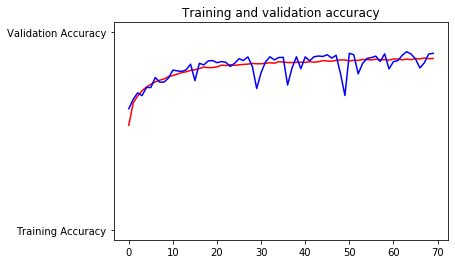

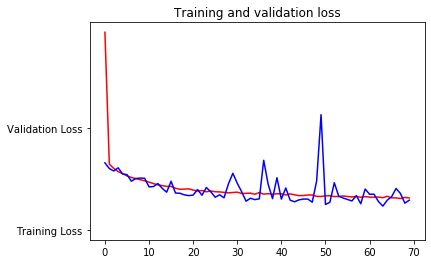

In [0]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')


In [0]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving 14.jpg to 14.jpg
[1.]
14.jpg is a dog
